In [107]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


# 1. Генерация данных с разным стандартным отклонением

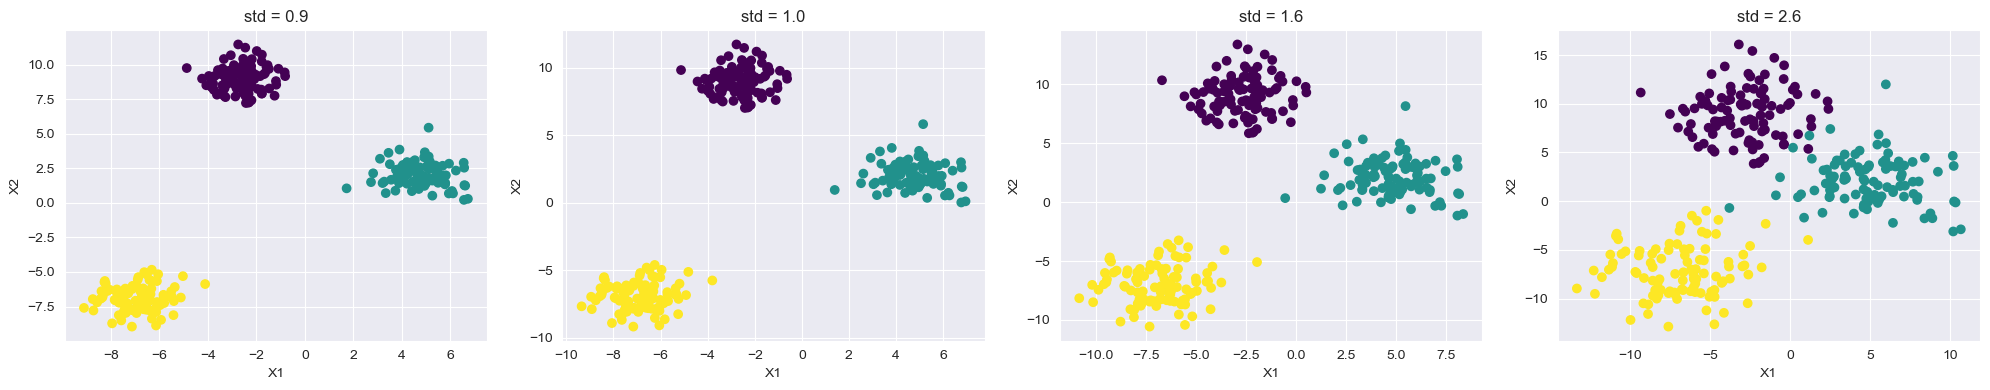

In [108]:
std_values = [0.9, 1.0, 1.6, 2.6]
fig, axes = plt.subplots(1, len(std_values), figsize=(20, 4))

for i, std in enumerate(std_values):
    X, y = make_blobs(n_samples=300, centers=3, cluster_std=std, random_state=42)
    axes[i].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    axes[i].set_title(f"std = {std}")
    axes[i].set_xlabel("X1")
    axes[i].set_ylabel("X2")

plt.tight_layout()
plt.show()


# 2. Разделение на обучающую и тестовую выборки

In [109]:
X, y = make_blobs(n_samples=300, centers=3, cluster_std=std_values[3], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. Реализация собственного алгоритма KNN

In [110]:
from collections import Counter


def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


def knn_predict(X_train, y_train, X_test, k):
    predictions = []
    for test_point in X_test:
        distances = [euclidean_distance(test_point, x) for x in X_train]
        k_indices = np.argsort(distances)[:k]
        k_labels = [y_train[i] for i in k_indices]
        most_common = Counter(k_labels).most_common(1)[0][0]
        predictions.append(most_common)
    return np.array(predictions)


# 4. Применение собственной функции и подбор оптимального k

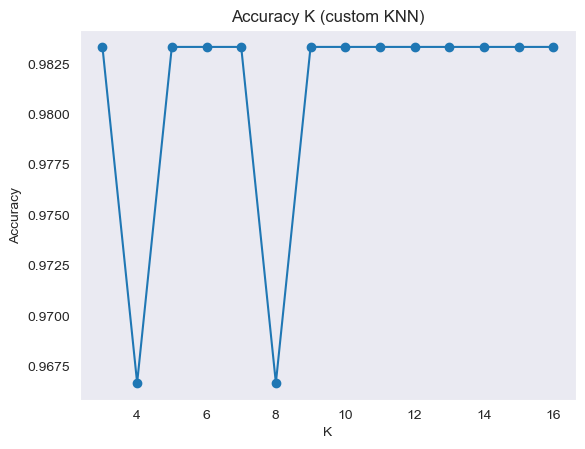

Best K: 3
k=3: accuracy=0.9833
k=4: accuracy=0.9667
k=5: accuracy=0.9833
k=6: accuracy=0.9833
k=7: accuracy=0.9833
k=8: accuracy=0.9667
k=9: accuracy=0.9833
k=10: accuracy=0.9833
k=11: accuracy=0.9833
k=12: accuracy=0.9833
k=13: accuracy=0.9833
k=14: accuracy=0.9833
k=15: accuracy=0.9833
k=16: accuracy=0.9833


In [111]:
accuracies = []
ks = range(3, 17)

for k in ks:
    y_pred = knn_predict(X_train, y_train, X_test, k)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

plt.plot(ks, accuracies, marker='o')
plt.title("Accuracy K (custom KNN)")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

best_k = ks[np.argmax(accuracies)]
print("Best K:", best_k)

for k, acc in zip(ks, accuracies):
    print(f"k={k}: accuracy={acc:.4f}")


Визуализация классифицированных точек:

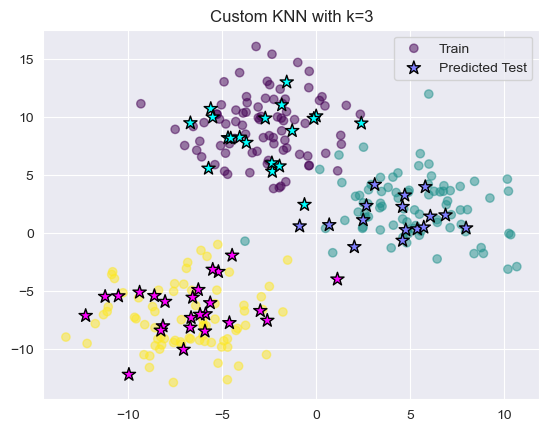

In [112]:
y_pred_best = knn_predict(X_train, y_train, X_test, best_k)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', label='Train', alpha=0.5)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_best, cmap='cool', edgecolors='k', marker='*', s=100,
            label='Predicted Test')
plt.legend()
plt.title(f"Custom KNN with k={best_k}")
plt.show()


# 5. Реализация с помощью Scikit-Learn

In [113]:
sk_model = KNeighborsClassifier(n_neighbors=best_k)
sk_model.fit(X_train, y_train)
y_sk_pred = sk_model.predict(X_test)


# 6. Сравнение с собственной реализацией

In [114]:
print("Custom KNN Accuracy:", accuracy_score(y_test, y_pred_best))
print("Sklearn KNN Accuracy:", accuracy_score(y_test, y_sk_pred))


Custom KNN Accuracy: 0.9833333333333333
Sklearn KNN Accuracy: 0.9833333333333333


# 7. Матрица несоответствий и метрики

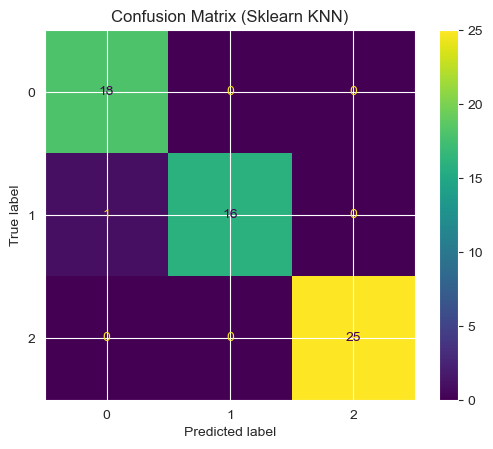

Accuracy: 0.9833
Precision (macro): 0.9825
Recall (macro): 0.9804
F1-score (macro): 0.9809
Класс 0: Specificity = 0.9762, Fall-out = 0.0238
Класс 1: Specificity = 1.0000, Fall-out = 0.0000
Класс 2: Specificity = 1.0000, Fall-out = 0.0000


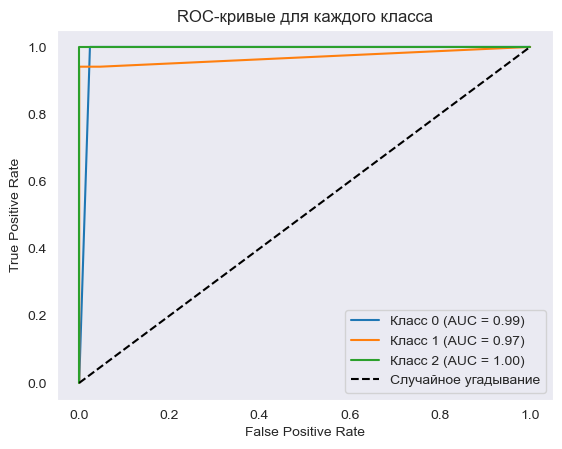

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score, roc_curve, roc_auc_score)
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

# Функция для вычисления специфичности и выпадения
def specificity_and_fallout(conf_matrix):
    n_classes = conf_matrix.shape[0]
    specificity_list = []
    fallout_list = []

    for i in range(n_classes):
        TP = conf_matrix[i, i]
        FP = sum(conf_matrix[:, i]) - TP
        FN = sum(conf_matrix[i, :]) - TP
        TN = conf_matrix.sum() - (TP + FP + FN)

        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        fallout = FP / (FP + TN) if (FP + TN) > 0 else 0

        specificity_list.append(specificity)
        fallout_list.append(fallout)

    return specificity_list, fallout_list

# Вычисление и вывод метрик
def evaluate_model(y_test, y_pred, conf_matrix):
    # Отображение матрицы несоответствий
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot()
    plt.title("Confusion Matrix (Sklearn KNN)")
    plt.show()

    # Метрики
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (macro)": precision_score(y_test, y_pred, average='macro'),
        "Recall (macro)": recall_score(y_test, y_pred, average='macro'),
        "F1-score (macro)": f1_score(y_test, y_pred, average='macro'),
    }

    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Специфичность и выпадение
    specificities, fallouts = specificity_and_fallout(conf_matrix)
    for i, (spec, fall) in enumerate(zip(specificities, fallouts)):
        print(f"Класс {i}: Specificity = {spec:.4f}, Fall-out = {fall:.4f}")

# Строим ROC-кривые и AUC
def plot_roc_curve(y_test, y_prob, y_train):
    y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(y_test_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
        plt.plot(fpr[i], tpr[i], label=f'Класс {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')
    plt.title('ROC-кривые для каждого класса')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Обучение классификатора KNN
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_sk_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)

# Матрица несоответствий
conf_matrix = confusion_matrix(y_test, y_sk_pred)

# Оценка модели
evaluate_model(y_test, y_sk_pred, conf_matrix)

# Построение ROC-кривых
plot_roc_curve(y_test, y_prob, y_train)
